### Dataset

#### experimental structure
5 runs <br>
12 trials per run <br>
4 conditions 
- cond 1: low GO, low U
- cond 2: low GO, high U
- cond 3: high GO, low U
- cond 4: high GO, high U <br>

No_subs = 49

No_conditions = 6 <br>
6 types of events per trial <br>
list of conditions: 'caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit' <br>

#### possibilities of modelling data per sub
- __one beta map per run__
- one beta map per x trials, x={1,2,3,6}
- one beta map per condition --> we will model conditions rather than the events within a trial

#### tutorial link
https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

In [2]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Data Loading and Visualization

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...
from nilearn.image import clean_img
beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)
#print('Number of beta maps: ', beta_maps_shape[-1])
#print('Shape of one beta map: ', beta_maps_shape[:-1]) # check: it should be (91, 109, 91, 30), meaning there are 30 3D images


Number of subjects:  49


## Creation of the mask

Shape of the mask:  (91, 109, 91)


C:\Users\User\miniforge3\lib\site-packages\nilearn\plotting\img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


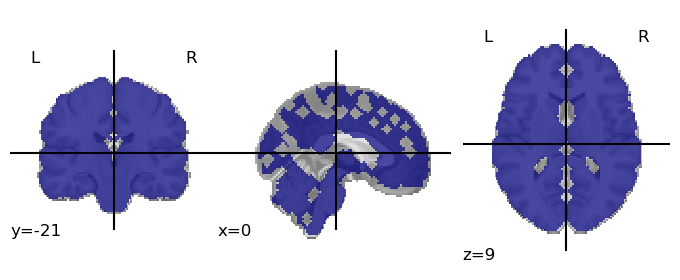

In [4]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy)

print('Shape of the mask: ', mask.shape)
plot_roi(mask)

## Masking the data

In [5]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:14<00:00,  3.48it/s]


In [6]:
print("We have 49 subjects, and for each of them there are 30 beta maps. Hence we have", samples.shape[0],
      "observations and",  samples.shape[1], "features")

print(samples.shape)

We have 49 subjects, and for each of them there are 30 beta maps. Hence we have 1470 observations and 216734 features
(1470, 216734)


## Labels 

In [7]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*nb_sub)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


## Unmask the data

In [8]:
# THIS IS NOT USED!!!
masked_epi = masker.inverse_transform(samples)
masked_epi.shape

(91, 109, 91, 1470)

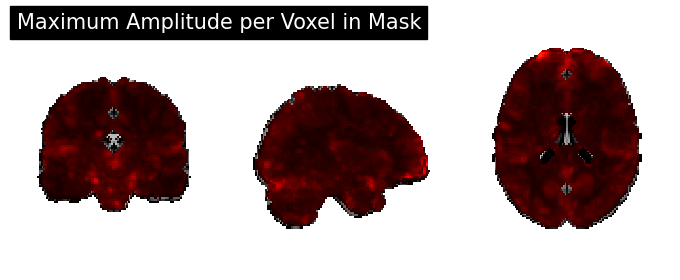

In [9]:
max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

## Train/Test Data Split

In [10]:
nb_test = 4
test_samples = samples[0:nb_test*30,:]
train_samples = samples[nb_test*30:nb_sub*30,:]

test_labels = labels[0:nb_test*30]
train_labels = labels[nb_test*30:nb_sub*30]

One way to do cross-validation is the so called Leave-one-out cross-validation. This approach trains on 6 chunks, and classifies the remaining chunk (one remaining), and repeats this for every chunk, also called fold. Therefore, a 7-fold cross-validation is one that divides the whole data into 7 different chunks.

--> train classifier using the data from 6 of the 7 runs, and then  test  accuracy at classifying the unseen data from the remaining run. 
--> 7 iterations, using all 7 combination of train & test run 

# Classification of conditions

### Cross Validation strategies
- 5-fold CV
- leave 1 run out across all subjects
- run a model per sub, leave 1 run out within subject (not done yet)

In [11]:
# for 5-fold CV (1st item in the email)
def make_chunks_per_5fold():
    chunks = []
    for _ in range(45): # Because 45 train subjects
        for i in range(5): # Because 5 runs
            chunks.append(i*np.ones((6,), dtype=int)) # Because 6 conditions
    chunks = np.concatenate(chunks)
    np.random.seed(3)
    np.random.shuffle(chunks)
    return chunks

In [12]:
# for 5-fold 9-subject CV (Alex's suggestion)
def make_chunks_per_9subjects():
    chunks = np.ravel([[i]*30 for i in range(45)])
    chunks = chunks % 5
    return chunks

In [13]:
# for leave-one-run-out across all subjects (2nd item in the email)
def make_chunks_per_run():
    chunks = []
    for _ in range(45): # Because 45 train subjects
        for i in range(5): # Because 5 runs
            chunks.append(i*np.ones((6,), dtype=int)) # Because 6 conditions
    chunks = np.concatenate(chunks)
    return chunks

In [14]:
chunks = {}

for key in ['per_5fold', 'per_9subjects', 'per_run'] :
    chunks[key]=eval('make_chunks_'+key)()

# to see the chunks
print(chunks['per_5fold'][0:50])
print(chunks['per_9subjects'][0:50])
print(chunks['per_run'][0:50])

[0 0 1 2 4 1 3 0 4 3 1 1 2 1 3 3 3 4 4 0 2 4 0 4 1 1 0 1 2 3 1 4 0 4 4 4 1
 0 3 4 4 3 3 3 1 4 2 4 0 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 0 0 0 0 0 0 1
 1 1 1 1 1 2 2 2 2 2 2 3 3]


### Baseline Model  : Ridge classifier, Multinomial Naive Bayes & MLPC, without features extraction & hyperparameter-tuning

In [15]:
classifiers = {'Ridge' :RidgeClassifier(), 'GNB': GaussianNB()}

for name, clf in classifiers.items() : 
    for key, chunk in chunks.items() : 
        print('\n'+ name + ','+ key + ' :' )
        cv_scores = cross_val_score(estimator=clf,
                            X=train_samples,
                            y=train_labels,
                            groups=chunk,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)
        
        #print score per fol & the mean of it
        print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
        print('Accuracy per fold:', cv_scores, sep='\n')


Ridge,per_5fold :


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.62274e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.55645e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.0416e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.50924e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", ove

Average accuracy = 72.30 percent

Accuracy per fold:
[0.74444444 0.71111111 0.68148148 0.76666667 0.71111111]

Ridge,per_9subjects :


C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.74377e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.91589e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=6.74356e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.33407e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\

Average accuracy = 61.93 percent

Accuracy per fold:
[0.63703704 0.69259259 0.62962963 0.53703704 0.6       ]

Ridge,per_run :


C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.23545e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.43902e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.18387e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.33018e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\User\miniforge3\lib\site-packages\sklearn\linear_model\

Average accuracy = 68.74 percent

Accuracy per fold:
[0.66296296 0.71481481 0.5037037  0.73333333 0.82222222]

GNB,per_5fold :


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 71.85 percent

Accuracy per fold:
[0.7037037  0.72962963 0.75925926 0.71111111 0.68888889]

GNB,per_9subjects :


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Average accuracy = 73.04 percent

Accuracy per fold:
[0.66296296 0.77407407 0.74444444 0.73333333 0.73703704]

GNB,per_run :
Average accuracy = 73.33 percent

Accuracy per fold:
[0.64444444 0.76666667 0.72592593 0.77037037 0.75925926]


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.3s finished


Samples : much more features than observations; Given that this small sample/feature ratio (usually) leads to overfitting, it follows that reducing the amount of features often has a beneficial effect on cross-validated performance estimates
- feature extraction: transform features into a set of lower-dimensional components (PCA)
- feature selection : select a subset of features (the one inside ROI, use univariate feature selection)
--> Let's try PCA 


### Features standardization + PCA + hyperparameter-tuning

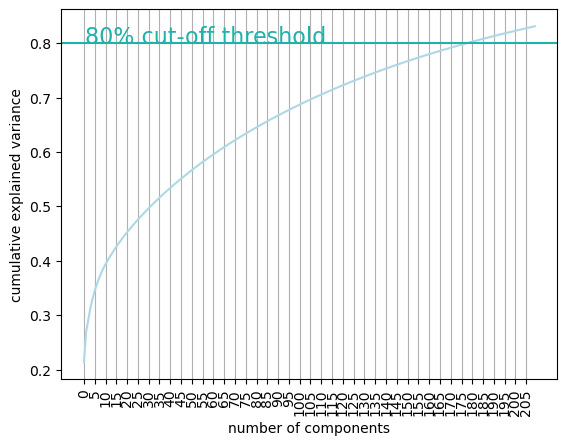

In [15]:
#standardization
scaler = MinMaxScaler()
scaler.fit(train_samples)
sample_std = scaler.transform(train_samples)
pca = PCA().fit(sample_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:210], color = 'lightblue')

#plot parameters 

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.8, color='lightseagreen', linestyle='-')
plt.text(0.5, 0.8, '80% cut-off threshold', color = 'lightseagreen', fontsize=16)
plt.xticks(np.arange(0, 210, step=5), rotation=90)
plt.grid(axis='x')
plt.show()


In [31]:
#pipeflow = standardization --> PCA --> Ridge classifier
pipe = Pipeline([('scale', MinMaxScaler()), ('pca', PCA(n_components=200)), ('Ridge',RidgeClassifier())])
    
#different parameters for hyperparameter-tuning
alpha= [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10]

# make lists of different parameters to check
param_grid = dict(Ridge__alpha=alpha) 
    
# initialization
grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'accuracy', verbose=1, n_jobs=1, cv = LeaveOneGroupOut())
    
#fit
for key, chunk in chunks.items():
    print(key+' : ')
    grid_result = grid.fit(train_samples, train_labels, groups = chunk)
    print(grid_result.cv_results_['mean_test_score'])
    #print score and params of the best model
    
    print('Best Score: ', grid_result.best_score_) #Mean cross-validated score of the best_estimator
    print('Best Params: ', grid_result.best_params_) 

per_5fold : 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[0.76740741 0.76740741 0.7637037  0.76518519 0.76296296 0.76296296
 0.76592593]
Best Score:  0.7674074074074074
Best Params:  {'Ridge__alpha': 1e-05}
per_9subjects : 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[0.75925926 0.76074074 0.75703704 0.75555556 0.76222222 0.76666667
 0.76148148]
Best Score:  0.7666666666666667
Best Params:  {'Ridge__alpha': 1}
per_run : 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[0.77703704 0.77703704 0.77037037 0.77777778 0.77037037 0.76888889
 0.77851852]
Best Score:  0.7785185185185185
Best Params:  {'Ridge__alpha': 10}


In [32]:
#pipeflow = Scale --> PCA --> Gaussian Naive Bayes
pipe = Pipeline([('scale', MinMaxScaler()), ('pca', PCA()),('GaussianNB' , GaussianNB())])

# initialization
n_components =[200]
params_NB = dict(pca__n_components=n_components)

grid_GNB = GridSearchCV(pipe, param_grid = params_NB ,scoring = 'accuracy', verbose=1, n_jobs=-1, cv = LeaveOneGroupOut()) 
    
#fit
for key, chunk in chunks.items():
    print(key+' : ') 
    grid_GNB_result = grid_GNB.fit(train_samples, train_labels, groups = chunk)
    
    #print score per fold
    print(grid_GNB_result.cv_results_['mean_test_score'])
    #print score and params of the best model
    print('Best Score: ', grid_GNB_result.best_score_) #Mean cross-validated score of the best_estimator
    print('Best Params: ', grid_GNB_result.best_params_) 

per_5fold : 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.55555556]
Best Score:  0.5555555555555556
Best Params:  {'pca__n_components': 200}
per_9subjects : 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.29555556]
Best Score:  0.29555555555555557
Best Params:  {'pca__n_components': 200}
per_run : 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.48444444]
Best Score:  0.4844444444444444
Best Params:  {'pca__n_components': 200}


## Neural Network test

In [33]:
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('MLPC' , MLPClassifier())])

parameter_space = {'MLPC__alpha': [1e-4, 1e-3, 1e-2]}

# initialization
grid_MLPC = GridSearchCV(pipe, param_grid=parameter_space, scoring = 'accuracy', verbose=1, n_jobs=1, cv = LeaveOneGroupOut())
    
#fit
for key, chunk in chunks.items():
    print(key+' : ')
    grid_MLPC_result = grid_MLPC.fit(train_samples, train_labels, groups = chunk)
    print(grid_MLPC_result.cv_results_['mean_test_score'])
    #print score and params of the best model
    
    print('Best Score: ', grid_MLPC_result.best_score_) #Mean cross-validated score of the best_estimator
    print('Best Params: ', grid_MLPC_result.best_params_) 

per_5fold : 
Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\User\miniforge3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

our best accuracy for now

# SpaceNet : SpaceNet: decoding with spatial structure for better maps

# Searchlight :  
small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation

In [16]:
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=mask,
                             max_iter=10, # We need to change this to 1000 but even 10 takes a lot of time
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

# We need to input 4D images to decoder.fit but we input a list of 4D images. I couldn't find a solution online :(
# I didn't use train_samples and train_labels beacuse decoder.fit wants NIFTI images
decoder.fit(beta_maps, labels)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a list of 4D images (5D). See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [17]:
# Prediction
test_pred = decoder.predict(test_samples)
# Return average accuracy
accuracy = (test_pred == test_labels).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
0.0

In [18]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

AttributeError: 'SpaceNetClassifier' object has no attribute 'coef_img_'

In [19]:
from nilearn.decoding import SearchLight
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain

In [20]:
sphere_radius = 8  # in mm

In [21]:
for name, clf in classifiers.items() : 
    for key, chunk in chunks.items() : 
        print('\n' + name + ','+ key+ ' : ')
        sl=SearchLight(mask, process_mask_img=mask,radius=sphere_radius, 
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=1,
                 verbose=1)
        sl.fit(beta_maps, labels, groups=chunk)
        searchlight_img = new_img_like(beta_maps[0], sl.scores_)
        plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy '+ name +' ' + key)



Ridge,per_5fold : 


DimensionError: Input data has incompatible dimensionality: Expected dimension is 4D and you provided a list of 4D images (5D). See https://nilearn.github.io/stable/manipulating_images/input_output.html.